<a href="https://colab.research.google.com/github/carvalheiracarlos/deep_leaning_notebooks/blob/main/alzheimer_cnn/train_alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.callbacks import ModelCheckpoint
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend
import tensorflow as tf
import json
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!mkdir weights

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
X_train = np.load('drive/MyDrive/alzheimer_datasets/X_train.npy', allow_pickle=True)
X_test = np.load('drive/MyDrive/alzheimer_datasets/X_test.npy', allow_pickle=True)

y_train = np.load('drive/MyDrive/alzheimer_datasets/y_train.npy', allow_pickle=True)
y_test = np.load('drive/MyDrive/alzheimer_datasets/y_test.npy', allow_pickle=True)

In [5]:
X_train[0].shape

(100, 100, 1)

In [6]:
class LightAlexNet:
  @staticmethod
  def build(n_channels, 
            rows, 
            cols, 
            n_classes, 
            activation='relu', 
            weights_path=None):
    model = tf.keras.models.Sequential()
    
    input_Shape = (rows, cols, n_channels)
    
    model.add(tf.keras.layers.Conv2D(filters=128, 
                                  kernel_size=(10,10),
                                  strides=(2,2),
                                  activation=activation, 
                                  input_shape=input_Shape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    
    
    model.add(tf.keras.layers.Conv2D(filters=256, 
                                  kernel_size=(8,8),
                                  strides=(2,2),
                                  activation=activation, 
                                  input_shape=input_Shape,
                                  padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    
    
    model.add(tf.keras.layers.Conv2D(filters=512, 
                                  kernel_size=(8,8),
                                  strides=(2,2),
                                  activation=activation, 
                                  input_shape=input_Shape,
                                  padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(0.5))


    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(512, activation=activation, kernel_regularizer=l2(0.01)))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))

    # if a weights path is supplied (inicating that the model was
    # pre-trained), then load the weights
    if weights_path is not None:
      model.load_weights(weights_path)
    
    return model

In [7]:
n_epochs = 100
ini_learning_rate = 1e-3
batch_size = 32

In [8]:
file_path = 'weights/alex_weights_train.h5'
check_point = ModelCheckpoint(file_path, 
                              monitor='categorical_accuracy', 
                              verbose=0, 
                              save_best_only=True,
                              mode='max',
                              save_weights_only=True)


tensorboard = tf.keras.callbacks.TensorBoard('./logs/fit/',
                                              write_images=True)

In [9]:
with tf.device('/device:GPU:0') as sess:
    train_model = LightAlexNet.build(n_channels=1, 
                                     rows=100,
                                     cols=100, 
                                     n_classes=4, 
                                     activation='relu', 
                                     weights_path=None)

    opt = tf.keras.optimizers.Adam(learning_rate=ini_learning_rate,
                                   beta_1=0.9, 
                                   beta_2=0.999, 
                                   epsilon=1e-08,
                                   decay=ini_learning_rate/n_epochs)
    
    train_model.compile(loss='categorical_crossentropy', 
                        optimizer=opt, 
                        metrics=[tf.keras.metrics.categorical_accuracy])

    train_model.summary()
    
    callbacks_list = [tensorboard, check_point]
    
    fit_history = train_model.fit(x=X_train,
                                  y=y_train,
                                  epochs=n_epochs,
                                  validation_split=0.3,
                                  validation_freq=1,
                                  batch_size=batch_size,
                                  callbacks=callbacks_list,
                                  verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 128)       12928     
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 128)      512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       2097408   
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 256)      1

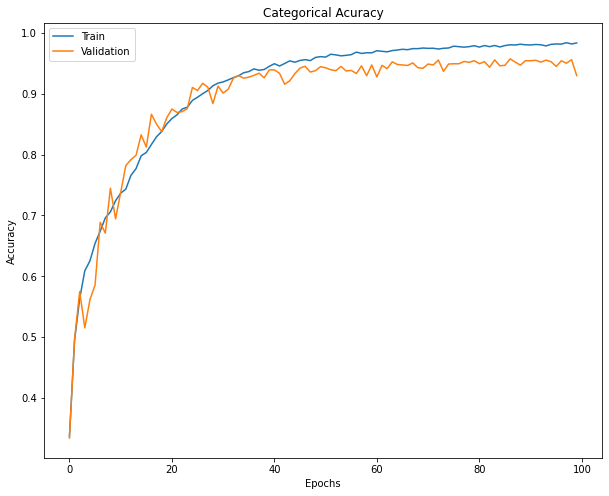

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.plot(fit_history.history['categorical_accuracy'], label='Train')
ax = plt.plot(fit_history.history['val_categorical_accuracy'], label='Validation')
ax = plt.xlabel('Epochs')
ax = plt.ylabel('Accuracy')
ax = plt.title('Categorical Acuracy')
ax = plt.legend()

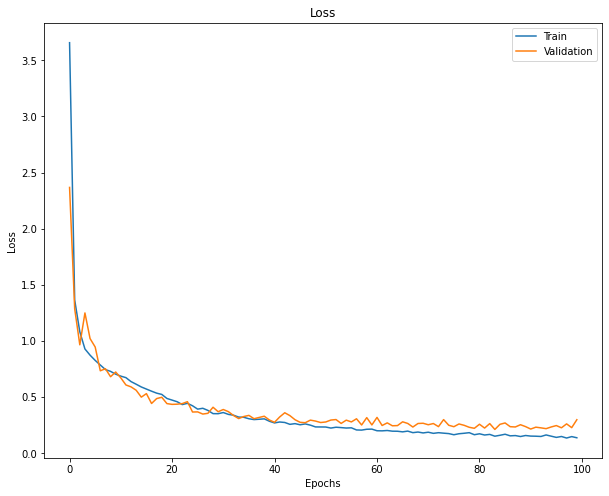

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = plt.plot(fit_history.history['loss'], label='Train')
ax = plt.plot(fit_history.history['val_loss'], label='Validation')
ax = plt.xlabel('Epochs')
ax = plt.ylabel('Loss')
ax = plt.title('Loss')
ax = plt.legend()